# Step 0: Load Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [ ]:
# Load the marketting dataset

train_data = pd.read_csv('Data/marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

### Let's select some columns that will be more usefull for our system

In [3]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 
                         'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head()

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,NaN,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."



## We'll start by looking at the tag column. Why tag?
### What is a Tag?
A tag is a **descriptor or label** assigned to an item to provide quick, high-level information about it. Tags are often crowdsourced (e.g., through user-generated tagging) or algorithmically generated and help categorize items for search, filtering, and recommendation purposes. Tags are especially useful in **content-based recommendation systems**, as they provide metadata that can be compared across items to determine similarity.

### Role of Tags in Recommendation Systems
1. **Content Representation**:
   - Tags capture important attributes of items, such as their genre, features, or other characteristics.
   - For example, in a movie dataset, tags might include "Action," "Romance," "1980s," or "Superhero."

2. **Feature Engineering**:
   - Tags serve as input features for algorithms in **content-based filtering**. The system compares the tags of items a user has interacted with against the tags of other items to find similarities.

3. **Enhanced Personalization**:
   - By matching tags to user preferences, the system can suggest items that align with the user's interests.
   - Example: If a user likes "Chip-Resistant" nail polish, the system might recommend other products with similar tags like "Long-Lasting."

### Common Sources of Tags:
1. **Crowdsourced Tags**: Users add tags to items based on their perception (e.g., on platforms like Goodreads or IMDB).
2. **Extracted Metadata**: Tags are derived from product descriptions, specifications, or attributes.
3. **Generated Tags**: Natural Language Processing (NLP) is used to generate tags by analyzing item descriptions or reviews.

In [4]:
train_data['Product Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Product Tags, Length: 5000, dtype: object

In [5]:
train_data.shape

(5000, 10)

In [6]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

### Letr's fill the missing values in the dataset

In [7]:
train_data['Product Rating'] = train_data['Product Rating'].fillna(0)
train_data['Product Reviews Count'] = train_data['Product Reviews Count'].fillna(0)
train_data['Product Category'] = train_data['Product Category'].fillna('')
train_data['Product Brand'] = train_data['Product Brand'].fillna('')
train_data['Product Description'] = train_data['Product Description'].fillna('')


In [8]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [9]:
# Check for duplicate

train_data.duplicated().sum()

np.int64(0)

### Let's consider renaming some columns for our convinience

In [10]:
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [11]:
train_data['ID']

0       1705736792d82aa2f2d3caf1c07c53f4
1       95a9fe6f4810fcfc7ff244fd06784f11
2       8d4d0330178d3ed181b15a4102b287f2
3       fddc4df45b35efd886794b261f730c51
4       0990cf89a59ca6a0460349a3e4f51d42
                      ...               
4995    2771f0606e9638de508741f52029d51c
4996    0f218eb3ac736975ccfdde987baa4b83
4997    34d1aa70845416c3df059a088aaf18dc
4998    ff9cfa22550bf036e2487a9100d927f1
4999    0de862f8c1c4f23b6c4cfe59fd574b59
Name: ID, Length: 5000, dtype: object

### Let's use regular expression (regex) to extract only the numeric parts of the strings in the 'ID' and 'ProdID' columns.

In [12]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [13]:
print(train_data['ID'].head)
print()
print(train_data['ProdID'].head)

<bound method NDFrame.head of 0       1.705737e+09
1       9.500000e+01
2       8.000000e+00
3       4.000000e+00
4       9.900000e+02
            ...     
4995    2.771000e+03
4996    0.000000e+00
4997    3.400000e+01
4998    9.000000e+00
4999    0.000000e+00
Name: ID, Length: 5000, dtype: float64>

<bound method NDFrame.head of 0         2.0
1        76.0
2         8.0
3         3.0
4         3.0
        ...  
4995    208.0
4996      1.0
4997     96.0
4998      7.0
4999      1.0
Name: ProdID, Length: 5000, dtype: float64>


# Step 2: EDA (Exploratory Data Analysis)

In [14]:
# Statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


In [15]:
heatmap_data = train_data.pivot_table('ID', 'Rating')
heatmap_data

,ID
Rating,
0.0,2.903881e+20
1.0,4.810669e+05
1.3,8.000000e+00
1.5,3.315000e+02
1.8,3.517850e+04
2.0,1.834903e+06
2.1,7.099400e+05
2.2,4.666667e+00
2.3,5.533333e+02


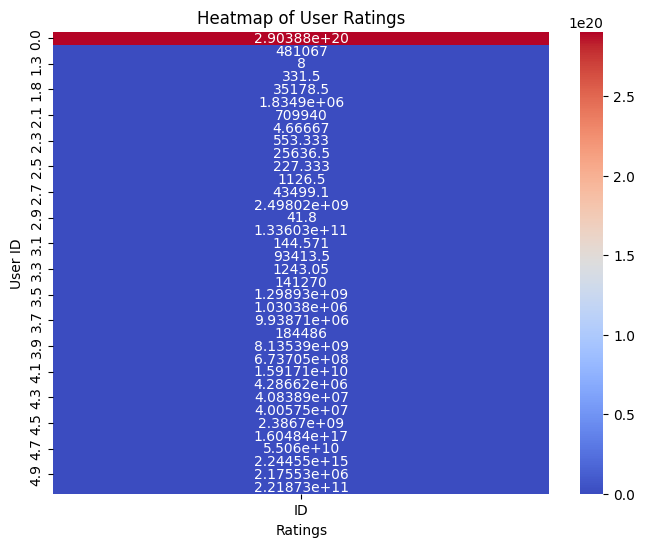

In [16]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

In [17]:
train_data['ID'].value_counts().head(20)

ID
7.0     224
2.0     218
6.0     214
8.0     206
0.0     204
3.0     197
9.0     197
4.0     195
5.0     190
1.0     189
72.0     23
67.0     20
80.0     19
29.0     19
70.0     19
13.0     18
14.0     18
23.0     18
90.0     17
82.0     17
Name: count, dtype: int64

In [18]:
train_data['ProdID'].value_counts().head(20)

ProdID
3.000000e+00    214
9.000000e+00    204
1.000000e+00    200
5.000000e+00    199
0.000000e+00    196
2.000000e+00    192
7.000000e+00    187
6.000000e+00    185
8.000000e+00    171
4.000000e+00    168
1.111104e+39     30
1.007940e+42     21
9.700000e+01     19
6.100000e+01     19
5.600000e+01     19
5.700000e+01     18
9.800000e+01     18
4.700000e+01     18
5.100000e+01     18
5.500000e+01     17
Name: count, dtype: int64

### Visualizing User and Item Interactions

In this step, we will explore the distribution of interactions within our dataset, focusing on how users interact with different products and the frequency of those interactions. In the code below, we will create two histograms:

1. **Interactions per User**: The first histogram visualizes how many interactions each user has made, providing insight into user behavior.
2. **Interactions per Item**: The second histogram shows how many interactions each product has received, helping to identify popular or heavily interacted-with products.

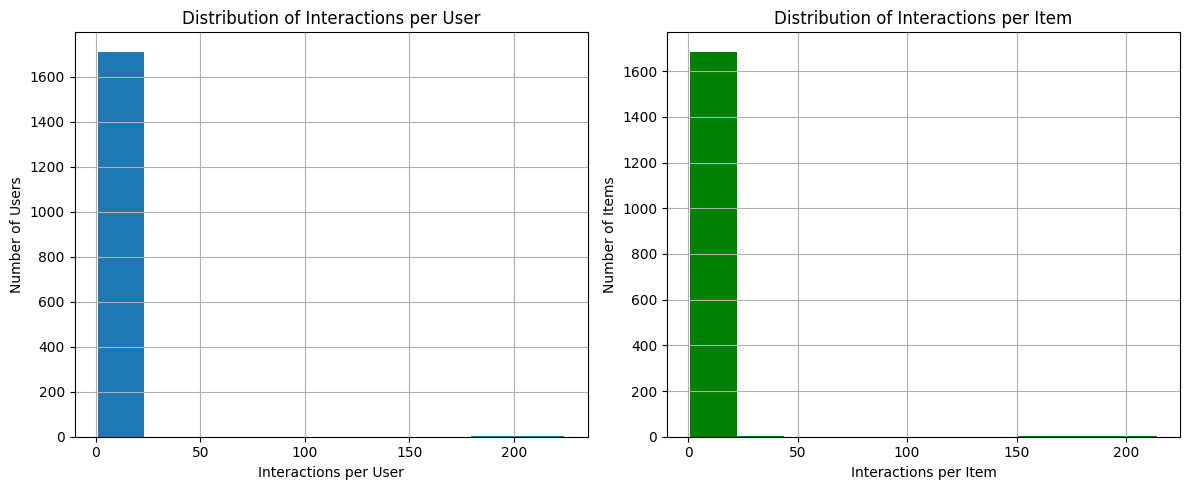

In [19]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10)
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

### Let's get the most popular products in the dataset.

we can get that using `".value_counts()"` which returns the values in a column and sorts them in descending order of frequency.

Text(0.5, 1.0, 'Most Popular items')

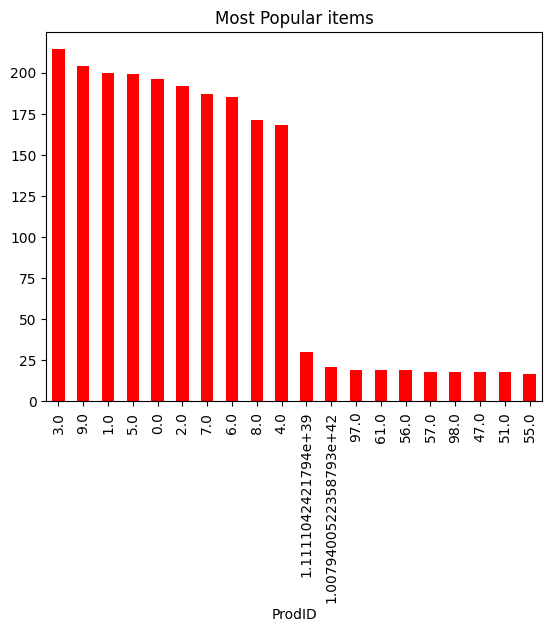

In [20]:
# Let's take 10 most popular

popular_items = train_data['ProdID'].value_counts().head(20)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

### Let's get the most common rating in the dataset.

We want to visualize how frequently each rating appears in the dataset, helping us to understand the distribution of ratings across users.

Text(0.5, 1.0, 'Most Common Ratings')

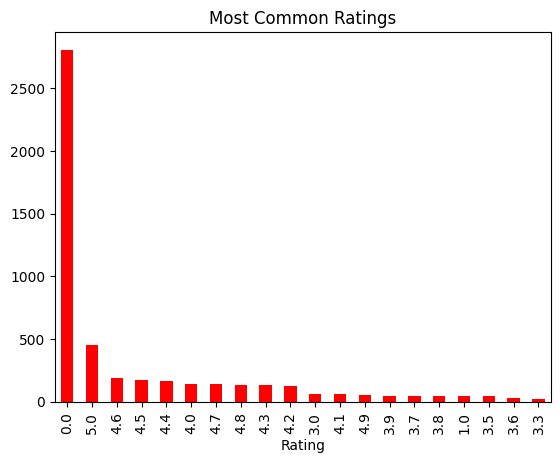

In [21]:
# The Most Common Rating

popular_items = train_data['Rating'].value_counts().head(20)
popular_items.plot(kind='bar',color='red')
plt.title("Most Common Ratings")

# Step 3: Data Cleaning and Tags Creations

In [22]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

### Let's create a function to extract tags from our dataset

In [23]:
def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

### Let's select columns to extract our tags from

In [24]:
columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

# Let's do the extraction
for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [25]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)
train_data['Tags']

0       premium, beauty, premium, makeup, premium, nai...
1       beauty, hair, care, hair, color, auburn, hair,...
2       beauty, hair, care, hair, color, permanent, ha...
3       beauty, makeup, lip, kokie, cosmetics, calling...
4       seasonal, stock, essentials, personal, care, s...
                              ...                        
4995    household, essentials, air, fresheners, spray,...
4996    beauty, hair, care, hair, color, permanent, ha...
4997    beauty, makeup, nails, stoneway, multifunction...
4998    premium, beauty, premium, bath, body, premium,...
4999    beauty, makeup, face, makeup, face, makeup, br...
Name: Tags, Length: 5000, dtype: object

# Rating Base Recommendations System


A **rating-based recommender system** generates recommendations by analyzing ratings given by users to items (such as products, movies, books, etc.). The primary goal is to offer **personalized recommendations** by considering how much a user has liked an item in the past, and using this information to suggest similar items they might also like. These systems are built on the premise that users who have agreed on some items (i.e., they gave similar ratings) will likely agree on other items as well.

### Key Concepts:

1. **User-Item Interactions**:
   - In a rating-based system, interactions between users and items are typically represented as a matrix, where each row corresponds to a user and each column corresponds to an item. The entries in the matrix are the ratings given by users to the items.
   - A typical example is movie recommendations, where each user rates movies on a scale (e.g., 1 to 5 stars).

2. **Collaborative Filtering**:
   - Collaborative filtering is the core technique used in rating-based recommender systems. There are two primary types:
     - **User-based Collaborative Filtering**: Recommends items by finding similar users based on their rating patterns. If two users have rated several items similarly, the system will recommend items liked by one user to the other.
     - **Item-based Collaborative Filtering**: Recommends items by finding similarities between items based on the ratings given by users. If many users who liked item A also liked item B, item B is recommended to users who liked item A.

3. **Matrix Factorization**:
   - **Matrix Factorization** methods like **Singular Value Decomposition (SVD)** and **Alternating Least Squares (ALS)** are used to reduce the dimensionality of the user-item interaction matrix, making the system more efficient. These methods work by decomposing the matrix into lower-rank matrices, capturing hidden patterns in the data, such as latent features of users and items.

4. **Challenges**:
   - **Sparsity**: Most users rate only a small fraction of available items, making the user-item matrix sparse. This can hinder the accuracy of recommendations as there is insufficient data for many users and items.
   - **Cold Start Problem**: The system struggles to recommend items for new users (user cold start) or new items (item cold start) that have no prior ratings.

5. **Evaluation Metrics**:
   - To assess the performance of a rating-based recommender system, metrics like **Root Mean Square Error (RMSE)**, **Mean Absolute Error (MAE)**, and **Precision/Recall** are used. These metrics help measure the accuracy of predicted ratings and the relevance of recommendations.

### Techniques for Rating-Based Recommendation Systems:

1. **Collaborative Filtering**:
   - Collaborative filtering relies on the idea that users who liked similar items in the past will continue to like similar items in the future. It is divided into:
     - **User-based**: Looks for users similar to the target user and recommends items that those users liked.
     - **Item-based**: Recommends items similar to those that the user has liked in the past.

2. **Matrix Factorization**:
   - These methods decompose large matrices of user-item ratings into smaller matrices to find hidden factors that explain observed ratings. Popular methods include **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**.

3. **Deep Learning Approaches**:
   - Recent advancements have seen the use of deep neural networks for recommendation tasks. Methods like **autoencoders** and **neural collaborative filtering (NCF)** are used to learn complex patterns in user-item interactions.

### Practical Examples of Rating-Based Recommender Systems:

- **Netflix**: Netflix uses collaborative filtering to recommend movies and TV shows. By analyzing users' viewing habits, Netflix can recommend movies similar to those a user has previously watched or liked, leveraging collaborative filtering.
- **Amazon**: Amazon's product recommendation engine uses item-based collaborative filtering to suggest products based on users’ past behavior, such as previous purchases or viewed items.

### Conclusion:

Rating-based recommender systems have evolved into powerful tools for providing personalized recommendations. They rely on user feedback (ratings) to suggest items that are most likely to be of interest. The methods range from traditional collaborative filtering approaches to more sophisticated matrix factorization and deep learning techniques. However, they face challenges such as sparsity and cold start problems, which researchers continue to address through various techniques and innovations.

### Sources:
- **"Collaborative Filtering"** on *ResearchGate*: This resource provides a thorough explanation of collaborative filtering and its variants, which are widely used in rating-based recommender systems.
- **"Recommender Systems: Challenges and Opportunities"** on *Medium*: This article discusses the challenges and solutions in recommendation systems, particularly focusing on rating-based models and their limitations.


In [26]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()
average_ratings

,Name,ReviewCount,Brand,ImageURL,Rating
0,$6 Mail-In Rebate Available Braun Epilator Sil...,146.0,braun,https://i5.walmartimages.com/asr/c7d78838-e8e2...,4.5
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
2,($11 Value) Love Beauty and Planet Coconut Wat...,278.0,"love, beauty, planet",https://i5.walmartimages.com/asr/0348d82d-2a13...,0.0
3,($125 Value) Impressions Vanity Touch Pro LED ...,2.0,"impressions, vanity",https://i5.walmartimages.com/asr/b886b154-97fd...,2.5
4,($129 Value) CHI G2 Ceramic Titanium Infused H...,23.0,chi,https://i5.walmartimages.com/asr/9bcc0ed7-d62c...,4.4
...,...,...,...,...,...
4987,"wet n wild Photo Focus Correcting Palette, Col...",12.0,"wet, n, wild",https://i5.walmartimages.com/asr/750275fb-ccfa...,3.3
4988,"wet n wild Photo Focus Liquid Foundation, Medi...",7827.0,"wet, n, wild",https://i5.walmartimages.com/asr/c2c5dc7e-9bbb...,0.0
4989,"wet n wild Photo Focus Pressed Powder, Dark Café",635.0,"wet, n, wild",https://i5.walmartimages.com/asr/57bd497f-0d5c...,4.2
4990,"wet n wild Silk Finish Lipstick, Honolulu Is C...",4259.0,"wet, n, wild",https://i5.walmartimages.com/asr/0e25f705-a924...,3.9


In [27]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)
rating_base_recommendation

,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0


In [28]:
rating_base_recommendation.loc[:, 'Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation

,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0


In [29]:
rating_base_recommendation.loc[:, 'ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)
rating_base_recommendation

,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0


In [30]:
print("Rating Base Recommendation System: (Trending Products)")
columns_to_select = ['Name', 'Rating', 'ReviewCount', 'Brand', 'ImageURL']
rating_base_recommendation.loc[:, columns_to_select] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0


# Content Base Recommendation system (User Preferences or Items similarities)

Here we are going to implement the content-based recommendation system by utilizing TF-IDF (Term Frequency-Inverse Document Frequency) and cosine similarity. These are used to transform the tags of items into numerical vectors and then calculates how similar each item is to every other item based on these vectors.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
# Importing the TfidfVectorizer to convert the text data into numerical vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Applying the vectorizer to the 'Tags' column and creating a sparse matrix of TF-IDF features
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
tfidf_matrix_content

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 260981 stored elements and shape (5000, 19548)>

### Let's calculate the cosine similarity between all items

In [33]:
# Calculating cosine similarity between all items based on the TF-IDF vectors
cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)
cosine_similarities_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

### Let's proceed to find similar items

We will begin by identifying the index of a specific item from the `train_data` DataFrame. Then, using this index, we find the similarity scores between the selected item and all other items based on their content features (e.g., tags, descriptions). After sorting these similarity scores in descending order, we will extract the top most similar items, which will be stored in the `recommended_items_indics` list. These indices represent the recommended items that are most similar to the selected product.


In [34]:
# Load the dataset of interest

train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,4.000000e+00,3.0,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","seasonal, stock, essentials, personal, care, s..."


### Let's look closer at the Name column with has the products name

In [35]:
train_data['Name']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice n Easy Permanent Color, 111 Natural Mediu...
2       Clairol Nice N Easy Permanent Color 7/106A Nat...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                                           Foundation
Name: Name, Length: 5000, dtype: object

### We'll use `'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'` to execute the similarity search
`

In [36]:
train_data['Name'].iloc[0]

'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

In [37]:
# Define the item for which we want to find similar items
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

# Get the index of the item from the train_data DataFrame based on its name on the "Name" column
item_index = train_data[train_data['Name'] == item_name].index[0]


# Compute the cosine similarity of the selected item with all other items in the dataset
similar_items = list(enumerate(cosine_similarities_content[item_index]))
similar_items

[(0, np.float64(1.0)),
 (1, np.float64(0.0034757732312750934)),
 (2, np.float64(0.0036322613839184243)),
 (3, np.float64(0.013151377769582695)),
 (4, np.float64(0.0010160210269512565)),
 (5, np.float64(0.006575809352364544)),
 (6, np.float64(0.007328463323503306)),
 (7, np.float64(0.05151153351231968)),
 (8, np.float64(0.011109860476686884)),
 (9, np.float64(0.003151730172379002)),
 (10, np.float64(0.0)),
 (11, np.float64(0.15874576284976777)),
 (12, np.float64(0.040980083610443314)),
 (13, np.float64(0.0030468898686792107)),
 (14, np.float64(0.0)),
 (15, np.float64(0.0059693458494800575)),
 (16, np.float64(0.3398806576145607)),
 (17, np.float64(0.0)),
 (18, np.float64(0.004556103655641239)),
 (19, np.float64(0.0038887588090144405)),
 (20, np.float64(0.008764149884645191)),
 (21, np.float64(0.0)),
 (22, np.float64(0.009458897953602717)),
 (23, np.float64(0.0)),
 (24, np.float64(0.005175585505049849)),
 (25, np.float64(0.0)),
 (26, np.float64(0.007172857177991527)),
 (27, np.float64(0.0

### Now let's sort the above items (items based on similarity score) in descending order


In [38]:
# Sort the items based on similarity score in descending order
similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

# Select the top 9 most similar items (excluding the item itself)
top_similar_items = similar_items[1:10]
top_similar_items

[(156, np.float64(1.0)),
 (184, np.float64(1.0)),
 (205, np.float64(1.0)),
 (237, np.float64(1.0)),
 (325, np.float64(1.0)),
 (375, np.float64(1.0)),
 (402, np.float64(1.0)),
 (706, np.float64(1.0)),
 (886, np.float64(1.0))]

In [39]:
# Extract the indices of the recommended items
recommended_items_indics = [x[0] for x in top_similar_items]
recommended_items_indics

[156, 184, 205, 237, 325, 375, 402, 706, 886]

In [40]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


# Function To Recommend Products for Content Base

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [42]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [43]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


# Collaborative Filtering (User Item Similarity)


We are going to implement collaborative filtering by creating a user-item matrix and calculating user similarity based on cosine similarity. We will be starting with the following:

1. **User-Item Matrix Creation**:  
   The `pivot_table` creates a matrix where each row represents a user (`ID`), each column represents a product (`ProdID`), and the values are the ratings given by users to products. Missing ratings are replaced with `0` and converted to integers.

2. **Cosine Similarity Calculation**:  
   `cosine_similarity` is then used to measure the similarity between users based on their ratings. The matrix `user_similarity` contains the similarity values between users, allowing for comparisons of how alike they are in their ratings.

3. **Identifying Similar Users**:  
   The target user (with ID `4`) is used to find similar users by sorting the cosine similarity scores. The top similar users (excluding the target user itself) are identified, and their indices are stored in `similar_user_indices` for use in generating recommendations.

This approach is part of **Collaborative Filtering**, which suggests items based on the preferences of similar users, rather than item characteristics.

In [44]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean')
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2.840000,1.376923,2.057143,1.587500,1.775000,0.000000,2.112500,1.975000,1.000000,1.011111,...,NaN,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN
1.000000e+00,1.720000,0.000000,2.122222,2.753846,0.700000,2.333333,3.325000,2.350000,0.000000,2.422222,...,NaN,4.700000,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2.000000e+00,1.285714,1.880000,3.062500,1.890909,2.663636,1.400000,0.766667,2.233333,1.336364,1.900000,...,NaN,3.100000,NaN,NaN,0.0,NaN,0.0,NaN,NaN,4.6
3.000000e+00,1.740000,1.125000,1.583333,2.675000,0.785714,3.314286,1.433333,0.000000,0.000000,3.540000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.000000e+00,3.525000,0.650000,2.462500,1.960000,1.550000,1.942857,0.415385,2.714286,1.866667,3.820000,...,NaN,1.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.094514e+14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.007694e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Let's fill the `NaN` values with `0`

In [45]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.000000e+00,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.007694e+17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Let's get the cosine similarity of the user items

In [46]:
cosine_similarity(user_item_matrix)
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[1.        , 0.08328508, 0.08776176, ..., 0.        , 0.03388371,
        0.        ],
       [0.08328508, 1.        , 0.09334828, ..., 0.        , 0.        ,
        0.        ],
       [0.08776176, 0.09334828, 1.        , ..., 0.        , 0.0417756 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.03388371, 0.        , 0.0417756 , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### To actualise this, let's consider working with any random user ID for example '`ID = 4'`

In [47]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)
target_user_index

4

In [48]:
# Using the target user index, we retrieve the similarity scores for that user against all others.

user_similarities = user_similarity[target_user_index]
user_similarities

array([0.0675362 , 0.0920999 , 0.044717  , ..., 0.        , 0.03691067,
       0.        ])

### Let's now find the most similar users

We will do that by sorting the similarity values in descending order (excluding the target user itself), and then get the indices of the top similar users.


In [49]:

# Find the most similar users:
similar_user_indices = user_similarities.argsort()[::-1][1:]
similar_user_indices

array([  84,  702, 1552, ..., 1009, 1008, 1023])

#### To explain the code above let's understand argsot()

1. **`argsort()`**:
   - The `argsort()` method is used on the `user_similarities` array (a 1D array or list of similarity scores) to return the indices that would sort the array in ascending order.
   - For example, if you had an array `[0.1, 0.7, 0.3]`, `argsort()` would return `[0, 2, 1]` because sorting the array in ascending order would place the values `0.1`, `0.3`, and `0.7` at indices `0`, `2`, and `1`, respectively.

2. **Reversing the order**:
   - The `[:: -1]` syntax is used to reverse the order of the indices returned by `argsort()`.
   - Reversing is crucial in this context because the `argsort()` function returns indices in ascending order, but for finding the **most similar** users, we need the indices in descending order. This is why we reverse the sorted indices to prioritize the highest similarity scores.

3. **Excluding the target user**:
   - The `[1:]` slice is used to exclude the first element (index `0`), which corresponds to the target user itself. Since we're looking for users similar to the target, the first element will always be the target user with a similarity score of `1` (because each user is identical to themselves). Excluding it ensures that only other users are considered.

### How `argsort()` works:
- `argsort()` sorts the array but returns the **indices** of the sorted values, not the sorted values themselves. This is useful when you need to access the original data associated with the sorted values. 

### Summary:
- **`argsort()`** gives indices for sorting.
- **`[::-1]`** reverses the order of those indices to sort them in descending order.
- **`[1:]`** excludes the first index (the target user), focusing only on other similar users.

### Here we want to generate recommendations for a `target user` based on items that `similar users` have rated but the target user has not.

The key steps include identifying items rated by similar users and filtering out those that the target user has already rated. Finally, we retrieve details of the recommended items from the dataset for presentation.

---

### Key Steps:
1. **Identify Items to Recommend**:  
   Compare the ratings of similar users and the target user to find items rated by similar users but not by the target user.
   Example: Hybrid Score=0.5×Content_Based_Score+0.5×Collaborative Score.

2. **Filter and Limit Recommendations**:  
   For efficiency, limit the number of recommendations to 10 per similar user to avoid an overwhelming number of suggestions.

3. **Retrieve Item Details**:  
   Extract meaningful information (e.g., name, reviews, brand) about the recommended items to present to the user.

In [50]:
similar_user_indices

array([  84,  702, 1552, ..., 1009, 1008, 1023])

In [51]:
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.000000e+00,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.007694e+17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
recommend_items = []

# Loop through the indices of similar users
for user_index in similar_user_indices:
    # Get the ratings provided by the similar user
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    
    # Identify items that are not rated by the target user but rated by the similar user
    not_rated_by_target_user = (rated_by_similar_user > 0) & (user_item_matrix.iloc[target_user_index] == 0)
    
    # Add up to 10 such items to the recommendation list
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

In [53]:
# Fetch details of the recommended items from the original dataset

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
1,"Nice n Easy Permanent Color, 111 Natural Mediu...",0.0,easy,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,0.0
5,Old Spice Artisan Styling High Hold Matte Fini...,52.0,"old, spice",https://i5.walmartimages.com/asr/73214b95-72ce...,4.6
6,"Colgate My First Baby and Toddler Toothpaste, ...",10.0,colgate,https://i5.walmartimages.com/asr/d28b16f4-1bd4...,4.3
9,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...,950.0,vaseline,https://i5.walmartimages.com/asr/6fced36e-5459...,0.0
10,"The Art of Shaving Mens Hair Styling Gel, Juni...",0.0,"art, shaving",https://i5.walmartimages.com/asr/661839a6-67ac...,0.0
11,"ORLY Nail Lacquer for Women, #20634 Red Carpet...",2.0,orly,https://i5.walmartimages.com/asr/e37d0f7d-defd...,4.5
12,"LOreal Paris True Match Super-Blendable Blush,...",184.0,paris,https://i5.walmartimages.com/asr/506a78ca-cca6...,3.8
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
19,"Crest Complete Whitening + Scope Toothpaste, 5...",249.0,crest,https://i5.walmartimages.com/asr/cb17ccbd-526a...,4.5
25,Better Homes & Gardens 100 mL Essential Oil Di...,128.0,"better, homes, gardens",https://i5.walmartimages.com/asr/080a3845-9eb8...,4.1


# Function That Recommend Items

In [54]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user > 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

In [55]:
# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
1,"Nice n Easy Permanent Color, 111 Natural Mediu...",0.0,easy,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,0.0
5,Old Spice Artisan Styling High Hold Matte Fini...,52.0,"old, spice",https://i5.walmartimages.com/asr/73214b95-72ce...,4.6
6,"Colgate My First Baby and Toddler Toothpaste, ...",10.0,colgate,https://i5.walmartimages.com/asr/d28b16f4-1bd4...,4.3
9,(3 pack) Vaseline Lip Therapy Tinted Lip Balm ...,950.0,vaseline,https://i5.walmartimages.com/asr/6fced36e-5459...,0.0
10,"The Art of Shaving Mens Hair Styling Gel, Juni...",0.0,"art, shaving",https://i5.walmartimages.com/asr/661839a6-67ac...,0.0
11,"ORLY Nail Lacquer for Women, #20634 Red Carpet...",2.0,orly,https://i5.walmartimages.com/asr/e37d0f7d-defd...,4.5
12,"LOreal Paris True Match Super-Blendable Blush,...",184.0,paris,https://i5.walmartimages.com/asr/506a78ca-cca6...,3.8
19,"Crest Complete Whitening + Scope Toothpaste, 5...",249.0,crest,https://i5.walmartimages.com/asr/cb17ccbd-526a...,4.5
25,Better Homes & Gardens 100 mL Essential Oil Di...,128.0,"better, homes, gardens",https://i5.walmartimages.com/asr/080a3845-9eb8...,4.1
31,Head & Shoulders Dandruff Conditioner Dry Scal...,0.0,"head, shoulders",https://i5.walmartimages.com/asr/a924d53f-007d...,0.0


# Hybrid Recommendations

### Overview of Hybrid Recommendation Systems

A **Hybrid Recommendation System** integrates two or more recommendation techniques to capitalize on their strengths and overcome individual weaknesses. This approach enhances the quality, accuracy, and diversity of recommendations by providing more comprehensive suggestions to users. Hybrid systems are widely used in applications like e-commerce, streaming platforms, and social networks.

---

#### Why Use Hybrid Recommendation Systems?

Standalone methods like **Content-Based Filtering** and **Collaborative Filtering** have their own limitations:
- **Content-Based Filtering** struggles with limited item metadata and over-specialization (recommends similar items only).
- **Collaborative Filtering** faces challenges with sparse data and "cold-start" issues for new users or items.

A hybrid system combines these methods, offering:
1. **Improved Accuracy**: By leveraging complementary data sources.
2. **Increased Diversity**: Merging different approaches avoids redundancy.
3. **Cold-Start Mitigation**: Balances user-based and item-based insights.
4. **Flexibility**: Customizable to different datasets and domains.

---

#### Types of Hybrid Recommendation Systems

1. **Weighted Hybrid**:
   - Combines scores or rankings from different models with predefined weights.

2. **Switching Hybrid**:
   - Switches between algorithms based on predefined rules or context (e.g., sparse data uses content-based filtering).

3. **Blended/Ensemble Hybrid**:
   - Merges the output of multiple models and removes duplicates.

4. **Feature Augmentation**:
   - Uses the output of one model as input features for another (e.g., collaborative filtering results as a feature for content-based filtering).

5. **Meta-Level Hybrid**:
   - Trains a new model using the predictions of other models as input.

---

#### Real-World Examples

1. **Netflix**:
   - Combines collaborative filtering (user preferences) with content-based filtering (movie metadata) for personalized suggestions.
   
2. **Amazon**:
   - Uses hybrid systems to recommend products based on user purchase history, browsing behavior, and item similarity.

3. **Spotify**:
   - Blends collaborative filtering (playlists of similar users) with audio feature analysis (content-based) for music recommendations.


In [56]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)

# Example usage: Let's get hybrid recommendations for user ID 4

You can always change the item_name to see what the output will look like

In [ ]:
target_user_id = 4 
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


# Example usage: Let's get hybrid recommendations for user ID 10


In [ ]:
target_user_id = 10 
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
